<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/denoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoise Network

## Google Setup

In [1]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
!git pull origin master
!pip install gputil
!pip install psutil
!pip install humanize
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


/content
Cloning into 'deepLearning'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 309 (delta 33), reused 33 (delta 13), pack-reused 245
Receiving objects: 100% (309/309), 150.34 MiB | 12.84 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Checking out files: 100% (101/101), done.
/content/deepLearning
From https://github.com/AlexMontgomerie/deepLearning
 * branch            master     -> FETCH_HEAD
Already up to date.
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
RAM Free: 12.9 GB  | Proc size: 143.4 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Setup

In [2]:
from common import *
!./setup.sh

Using TensorFlow backend.


--2019-03-07 17:15:22--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.24.197, 107.152.25.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-07 17:15:22--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-07 17:15:23--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcolleg

## Get Denoise Model (Add)

In [3]:
from denoise_network import *
from get_data import get_data

EPOCHS = 50

seqs_train, seqs_test = get_data()

# get traning data

denoise_generator     = DenoiseHPatches(seqs_train, batch_size=500)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=500)
    #np.save('data/denoise_data/denoise_generator.npy'    , denoise_generator    )
    #np.save('data/denoise_data/denoise_generator_val.npy', denoise_generator_val)


100%|██████████| 40/40 [00:41<00:00,  1.01s/it]


In [4]:

import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt

# denoise model
def get_denoise_model(shape):

  inputs = Input(shape)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)

  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)

  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_unet = Model(inputs = inputs, outputs = conv4)
  return shallow_unet

# optimiser
opt  = opt = keras.optimizers.nadam()

# train network
def ssim_loss(clean,noisy):
  return 1 - tf.image.ssim(clean, noisy, max_val=1.0)


Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# get model
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model_mae.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

denoise_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])
denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=EPOCHS, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
3117/3117 [==============================] - 611s 196ms/step - loss: 7.5346 - acc: 0.0537 - val_loss: 5.9604 - val_acc: 0.0679

Epoch 00001: val_loss improved from inf to 5.96037, saving model to data/denoise_model_mae.weights.01-5.96.hdf5
Epoch 2/50
3117/3117 [==============================] - 604s 194ms/step - loss: 5.8847 - acc: 0.0654 - val_loss: 5.5976 - val_acc: 0.0702

Epoch 00002: val_loss improved from 5.96037 to 5.59763, saving model to data/denoise_model_mae.weights.02-5.60.hdf5
Epoch 3/50
3117/3117 [==============================] - 604s 194ms/step - loss: 5.5918 - acc: 0.0721 - val_loss: 5.4552 - val_acc: 0.0783

Epoch 00003: val_loss improved from 5.59763 to 5.45522, saving model to data/denoise_model_mae.weights.03-5.46.hdf5
Epoch 4/50
3117/3117 [==============================] - 608s 195ms/step - loss: 5.4160 - acc: 0.0792 - val_loss: 5.4160 - val_acc: 0.0694

Epoch 00004: val_loss improved from 5.45522 to 5.415

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


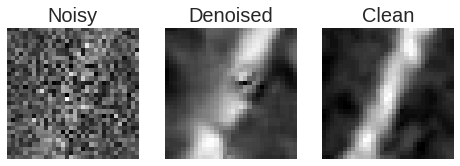

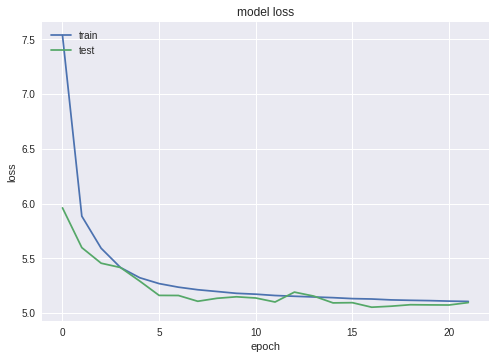

In [6]:
plot_denoise(denoise_model)
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
# get model
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model_ssim.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

denoise_model.compile(loss=ssim_loss, optimizer=opt, metrics=['accuracy'])
denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=EPOCHS, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Epoch 1/50
3117/3117 [==============================] - 639s 205ms/step - loss: 0.9913 - acc: 1.4757e-04 - val_loss: 0.4483 - val_acc: 0.0105

Epoch 00001: val_loss improved from inf to 0.44830, saving model to data/denoise_model_ssim.weights.01-0.45.hdf5
Epoch 2/50
3117/3117 [==============================] - 640s 205ms/step - loss: 0.3413 - acc: 0.0346 - val_loss: 0.3444 - val_acc: 0.0469

Epoch 00002: val_loss improved from 0.44830 to 0.34443, saving model to data/denoise_model_ssim.weights.02-0.34.hdf5
Epoch 3/50
3117/3117 [==============================] - 641s 206ms/step - loss: 0.3295 - acc: 0.0373 - val_loss: 0.3448 - val_acc: 0.0502

Epoch 00003: val_loss did not improve from 0.34443
Epoch 4/50
3117/3117 [==============================] - 642s 206ms/step - loss: 0.3271 - acc: 0.0380 - val_loss: 0.3420 - val_acc: 0.0495

Epoch 00004: val_loss improved from 0.34443 to 0.34197, saving model to data/denoise_model_ssim.weights.04-0.34.hdf5
Epoch 5/50
3117/3117 [====================

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


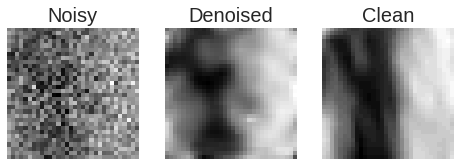

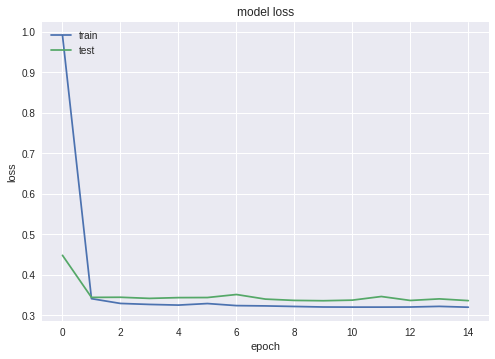

In [8]:
plot_denoise(denoise_model)
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# get model
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

# train network
def snr_loss(clean,noisy):
  tmp = tf.image.psnr(clean, noisy, max_val=1.0)
  print(tmp)
  return - tmp

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model_snr.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

denoise_model.compile(loss=snr_loss, optimizer=opt, metrics=['accuracy'])
denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=EPOCHS, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Tensor("loss_2/conv2d_15_loss/PSNR/Identity_3:0", shape=(?,), dtype=float32)
Epoch 1/50
3117/3117 [==============================] - 602s 193ms/step - loss: 17.0054 - acc: 0.0727 - val_loss: 16.0476 - val_acc: 0.0864

Epoch 00001: val_loss improved from inf to 16.04762, saving model to data/denoise_model_snr.weights.01-16.05.hdf5
Epoch 2/50
3117/3117 [==============================] - 601s 193ms/step - loss: 16.1871 - acc: 0.0824 - val_loss: 15.7737 - val_acc: 0.0843

Epoch 00002: val_loss improved from 16.04762 to 15.77366, saving model to data/denoise_model_snr.weights.02-15.77.hdf5
Epoch 3/50
3117/3117 [==============================] - 600s 192ms/step - loss: 16.0537 - acc: 0.0838 - val_loss: 16.0697 - val_acc: 0.0744

Epoch 00003: val_loss did not improve from 15.77366
Epoch 4/50
3117/3117 [==============================] - 599s 192ms/step - loss: 15.9786 - acc: 0.0845 - val_loss: 16.2356 - val_acc: 0.0649

Epoch 00004: val_loss did not improve from 15.77366
Epoch 5/50
3117/3117 [

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


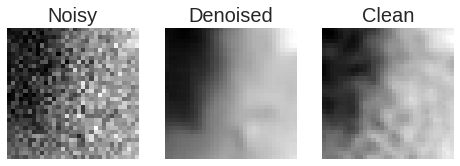

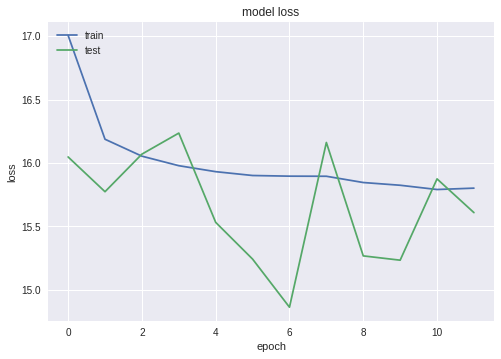

In [10]:
plot_denoise(denoise_model)
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt


def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  

from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))


### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=True)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)
epochs = 50
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

# callbacks
callbacks = [
    #keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/descriptor_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=40, callbacks=callbacks,
                                              verbose=1, validation_data=val_generator)
